In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Online Retail.zip"

Archive:  /content/drive/My Drive/Online Retail.zip
  inflating: Online Retail.xlsx      
  inflating: __MACOSX/._Online Retail.xlsx  


In [ ]:
!pip install --upgrade openpyxl

**Exploratery Data Analysis**

In [ ]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

**Load the Dataset**

In [ ]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.Country.value_counts().reset_index().head(20)

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


As above we have seen the major count is from United kingdom will be restricted to it which contains most of our customers historical data.

In [ ]:
uk = df[df['Country']=='United Kingdom']
uk.shape

(495478, 8)

**Remove Cancelled Orders or having negative transactions**

In [ ]:
uk = uk[uk['Quantity']>0]
uk.shape

(486286, 8)

**Remove rows where CustomerID are NA or having missing values**

In [ ]:
uk.dropna(subset=['CustomerID'],how='all',inplace=True)
uk.shape

(354345, 8)

**Restricting the data to one year because it's better to use a metric per Months or Years in RFM**

In [ ]:
uk = uk[uk['InvoiceDate']>= "2010-12-09"]
uk.shape

(342478, 8)

In [ ]:
data= uk
data.to_csv(('/content/drive/MyDrive/data.csv'))

In [ ]:
print("Summary..")
#exploring the unique values of each attributes
print("Number of transactions: ", uk['InvoiceNo'].nunique())
print("Number of products bought: ",uk['StockCode'].nunique())
print("Number of customers:", uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(uk['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Summary..
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


***RFM Analysis***

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that divides customers into groups based on past purchase behaviour.

RFM assists in categorising customers into different groups or clusters in order to identify customers who are more likely to respond to promotions and also for future personalization services.

We will create those 3 customer attributes for each customer

**Recency**

To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase.**

In [ ]:
#The last date available in our dataset
uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [ ]:
import time, warnings
import datetime as dt
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [ ]:
#create a new column called date which contains the date of invoice only
uk['date'] = uk['InvoiceDate'].dt.date

In [ ]:
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [ ]:
#group by customers and check last date of purshace
recency_df = uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaseDate']
recency_df.head()

,CustomerID,LastPurshaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [ ]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaseDate'].apply(lambda x: (now - x).days)

In [ ]:
recency_df.head()

,CustomerID,LastPurshaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [ ]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaseDate',axis=1,inplace=True)

In [ ]:
recency_df.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


Now we have the recency attribute created. e.g: Customer with ID = 12346 did his/her last purshace 325 days ago.

**Frequency**-

Frequency helps us to know **how many times a customer purchased from us**.

To do that we need to check how many invoices are registered by the same customer.

In [ ]:
# drop duplicates
uk_copy = uk
uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


**Monetary**

Monetary attribute answers the question: **How much money did the customer spent over time?**


To do that, first, we will create a new column total cost to have the total price per invoice.

In [ ]:
#create column total cost
uk['TotalCost'] = uk['Quantity'] * uk['UnitPrice']

In [ ]:
monetary_df = uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


**Create RFM Table**

In [ ]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [ ]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


Customer with ID = 12346 has recency: 325 days, frequency:1, and monetary: 77183,60 £.

**RFM Table Verification**

In [ ]:
uk[uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


As we can see our RFM table is correct. The first customer bought only once, and only one product with huge amount.

**Customer segments with RFM Model**

Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

**Pareto’s rule says 80% of the results come from 20% of the causes.**

Similarly, 20% customers contribute to 80% of your total revenue. 

Let's verify that because that will help us know which customers to focus on when marketing new products.

**Applying 80-20 rule**

In [ ]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  890679.54


In [ ]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


**Top Customers**

In [ ]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


In [ ]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [ ]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 773]['Monetary'].sum()
revenueByTop20

976841.05

In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are less than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

## **Applying K-means clustering on RFM variables**

**Preprocess Data**

In [ ]:
rfm_data=rfm_df
rfm_data.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


In [ ]:
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.279236,-0.027727,0.323091
Frequency,-0.279236,1.000000,0.156431,-0.458849
Monetary,-0.027727,0.156431,1.000000,-0.130520
Rank,0.323091,-0.458849,-0.130520,1.000000


**Data Normalization**

In [ ]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [ ]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [ ]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


In [ ]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.364351,0.715609
Recency,-0.364351,1.000000,-0.569951
Frequency,0.715609,-0.569951,1.000000


## **K - Means Clustering**

To Find optimal number of clusters,we used Elbow method where errors are plotted against K (cluster value) to identify optimal number of clusters

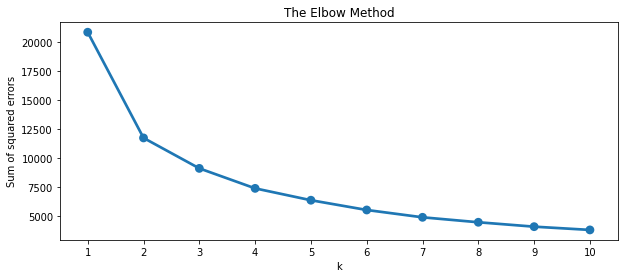

In [ ]:
data_norm = log_data[["Recency", "Frequency", "Monetary"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the above plot, we can see that the optimal number of clusters can be taken as 2.

## **K-means Implementation**
A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The elbow method can be used to determine the number of clusters as well.

In [ ]:
matrix = log_data
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.38940554101987457
For n_clusters = 3 The average silhouette_score is : 0.30561967843301635
For n_clusters = 4 The average silhouette_score is : 0.3096566189062348
For n_clusters = 5 The average silhouette_score is : 0.2900384811306346
For n_clusters = 6 The average silhouette_score is : 0.2951519419132616
For n_clusters = 7 The average silhouette_score is : 0.29128648080510633
For n_clusters = 8 The average silhouette_score is : 0.29146891086015536
For n_clusters = 9 The average silhouette_score is : 0.2953614367144479


The **best silhouette score** obtained is when the **number of clusters is 2.**

In [ ]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.389


**Visualize Clusters**

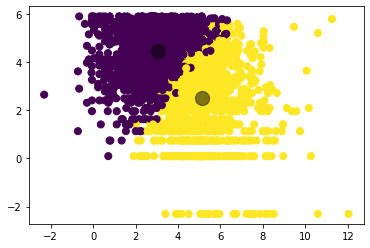

In [ ]:
#create a scatter plot
plt.scatter(matrix.iloc[:, 0], matrix.iloc[:, 1], c=clusters_customers, s=50, cmap='viridis');
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

###**DBSCAN ALGORITHM**

# Building the Model

In [ ]:
# create an object
db = DBSCAN(eps=0.8, min_samples=100, metric='euclidean')

# fit the model
db.fit(log_data)
y_pred = db.fit_predict(log_data)

In [ ]:
core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
core_samples_mask

array([False, False, False, ..., False, False, False])

In [ ]:
y_pred

array([-1, -1, -1, ...,  0, -1,  0])

In [ ]:
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([False, False, False, ..., False, False,  True])

In [ ]:
# Cluster labled
labels = db.labels_

In [ ]:
labels

array([-1, -1, -1, ...,  0, -1,  0])

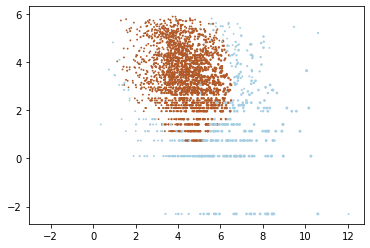

In [ ]:
plt.scatter(log_data['Monetary'],log_data['Recency'],log_data['Frequency'],c=y_pred,cmap="Paired")
plt.show()

In [ ]:
n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print('No. of cluster in the dataset =',n_cluster)
print('No. of noise data sample in dataset=', n_noise)

No. of cluster in the dataset = 1
No. of noise data sample in dataset= 549


# Evaluation

### Silhouette

In [ ]:
cluster_labels = db.labels_   

# silhouette score
silhouette_avg = silhouette_score(log_data, cluster_labels)
print("The silhouette score is", format(silhouette_avg))


The silhouette score is 0.38491471085955686


In [ ]:
log_data['label']=db.labels_

log_data.head()

,Monetary,Recency,Frequency,label
CustomerID,,,,
12346.0,11.253944,5.784133,0.000000,-1
12747.0,6.490708,0.741937,2.302585,-1
12748.0,8.226662,-2.302585,5.278115,-1
12749.0,4.589549,1.131402,1.609438,0
12820.0,4.065602,1.131402,1.386294,0


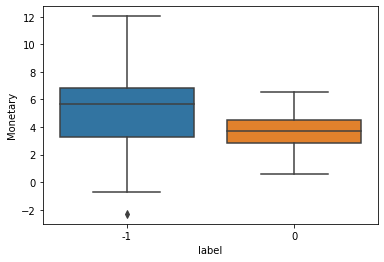

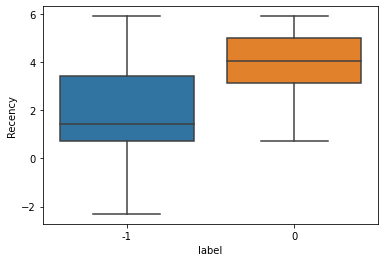

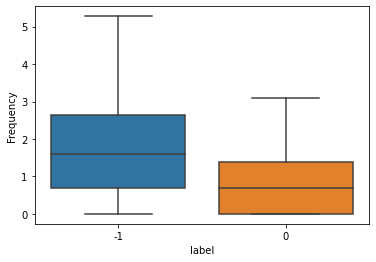

In [ ]:
for c in log_data.columns[:-1]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=log_data, y=c, x='label')
    plt.show()